<a href="https://colab.research.google.com/github/cgoeser1/MSDS422_course_assignments/blob/main/AmesHousing(2021OCT10).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Conduct EDA on the dataset as follows:**
* Provide appropriate descriptive statistics and visualizations to help understand the **marginal distribution** of the dependent variable.
* Investigate **missing data** and **outliers**.
* Investigate at least **three potential predictors** of the dependent variable and provide appropriate graphs / statistics to demonstrate the relationships.
* Engage in **feature creation** by splitting, merging, or otherwise generating a new predictor.
* Using the dependent variable, perform both **min-max and standard scaling** in Python.
#Checkpoint 2
* Conduct your analysis using a **cross-validation** design.
* Conduct EDA and provide appropriate **visualizations** in the process.
* Build a minimum of **two separate regression models** using the training set.
* Evaluate **polynomial, indicator, dichotomous, & piecewise** model components.
* **Create at least one feature** from the data set.
* Evaluate the models’ **assumptions**.
* Evaluate **goodness of fit** metrics on the training and validation sets.
* Submit predictions for the unseen test set available on **Kaggle.com**.
* Provide your Kaggle user name and a screen snapshot of your **Kaggle scores**.
* Discuss what your models tell you in **layman’s terms**

Import all relevant packages.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import seaborn as sns
from scipy import stats

# to make this notebook's output stable across runs
np.random.seed(31)


# To plot pretty figures
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Clone the repository, so all files are in the same folder.  Should be accessible to all collaborators.

In [2]:
!git clone https://github.com/cgoeser1/MSDS422_course_assignments


Cloning into 'MSDS422_course_assignments'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 32 (delta 16), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (32/32), done.


Change the Colab working directory to that just cloned from GitHub.
Confirm the working directory.

In [3]:
os.chdir('/content/MSDS422_course_assignments')
os.getcwd()

'/content/MSDS422_course_assignments'


Load train and test files into Pandas dataframes.

In [4]:
## Get data from the provided CSV files.
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Check the number of observations for each feature in the 'train' set.

[Text(0.5, 1.0, 'SalePrice - High')]

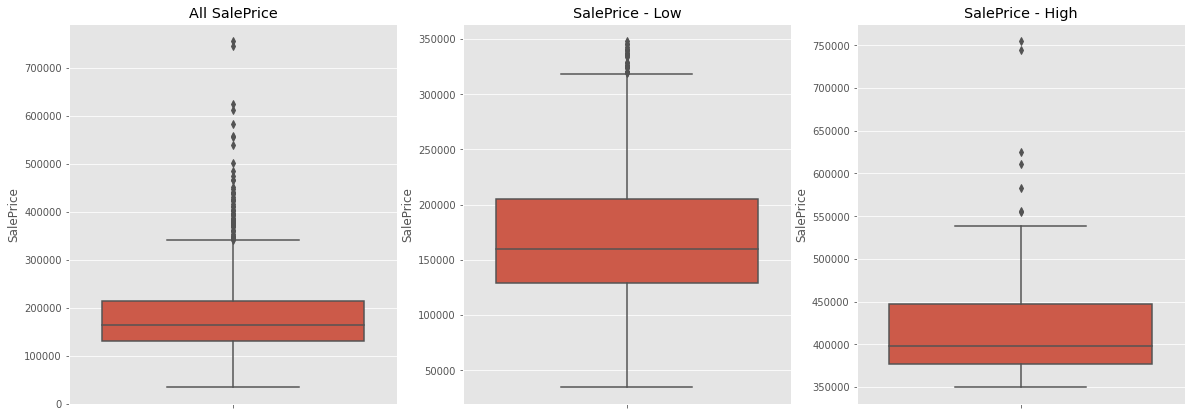

In [5]:
## Check for Outliers. It looks like $350,000 is the max of IQR, 
## so it may make sense to split into two sets ('low' and 'high') based on this price.
train_low = train[train.SalePrice<350000]
train_hi = train[train.SalePrice>=350000]

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(20,7), sharey=False)
sns.boxplot(y=train['SalePrice'], data=train, ax=ax0).set(title='All SalePrice')
sns.boxplot(y=train_low['SalePrice'], data=train_low, ax=ax1).set(title='SalePrice - Low')
sns.boxplot(y=train_hi['SalePrice'], data=train_hi, ax=ax2).set(title='SalePrice - High')

In [6]:
### **Investigate missing data.
## count the number of features.
print(len(train.columns))
train.info()

81
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  Overa

### **Marginal distribution of the SalePrice.**

In [7]:
## Do a quick statistical summary of the train data set SalePrice. -cpg
print(f"Mean Housing Price: ${train.SalePrice.mean():,.2f}.")
print(f"Median Housing Price: ${train.SalePrice.median():,.2f}.")

Mean Housing Price: $180,921.20.
Median Housing Price: $163,000.00.


## **Investigate Outliers**

In [8]:
## Check for Outliers. It looks like $350,000 is the max of IQR, 
## so it may make sense to split into two sets ('low' and 'high') based on this price.
train_low = train[train.SalePrice<350000]
train_hi = train[train.SalePrice>=350000]

[Text(0.5, 1.0, 'SalePrice - High')]

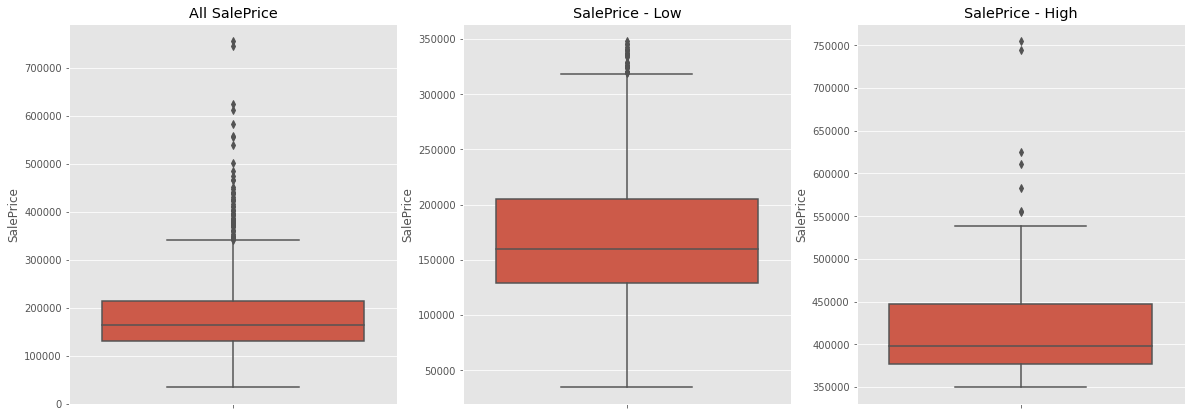

In [9]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(20,7), sharey=False)
sns.boxplot(y=train['SalePrice'], data=train, ax=ax0).set(title='All SalePrice')
sns.boxplot(y=train_low['SalePrice'], data=train_low, ax=ax1).set(title='SalePrice - Low')
sns.boxplot(y=train_hi['SalePrice'], data=train_hi, ax=ax2).set(title='SalePrice - High')

### **Investigate missing data.**

In [10]:
## Identify the features missing values, so we can determine whether to drop the feature or impute the data.
## Will revisit dropping features later.  Prof. Anil suggests that we can do it better
## by determing the "degree of randomness" of the missing data. 
missing = train.isna().sum()
missing = missing[missing>0]
missing_perc = missing/train.shape[0]*100
missinglist = pd.DataFrame([missing, missing_perc], index = ['missing_num', 'missing_perc']).T
missinglist = missinglist.sort_values(by = 'missing_perc', ascending = False)
print(missinglist)

              missing_num  missing_perc
PoolQC             1453.0     99.520548
MiscFeature        1406.0     96.301370
Alley              1369.0     93.767123
Fence              1179.0     80.753425
FireplaceQu         690.0     47.260274
LotFrontage         259.0     17.739726
GarageType           81.0      5.547945
GarageFinish         81.0      5.547945
GarageQual           81.0      5.547945
GarageCond           81.0      5.547945
BsmtExposure         38.0      2.602740
BsmtFinType2         38.0      2.602740
BsmtFinType1         37.0      2.534247
BsmtCond             37.0      2.534247
BsmtQual             37.0      2.534247
MasVnrArea            8.0      0.547945
MasVnrType            8.0      0.547945
Electrical            1.0      0.068493


### **Consider Imputing and/or dropping features.**

In [11]:
### **Consider Imputing and/or dropping features.**
  ## replace na with 0 for the folowing columns 
train['BsmtUnfSF']= train['BsmtUnfSF'].fillna(0)
train['TotalBsmtSF']= train['TotalBsmtSF'].fillna(0)
train['GarageArea']= train['GarageArea'].fillna(0)
train['GarageCars']= train['GarageCars'].fillna(0)
train['BsmtFinSF1']= train['BsmtFinSF1'].fillna(0)
train['BsmtFinSF2']= train['BsmtFinSF2'].fillna(0)
train['LotFrontage']= train['LotFrontage'].fillna(0)
train['BsmtFullBath']= train['BsmtFullBath'].fillna(0)
train['BsmtHalfBath']= train['BsmtHalfBath'].fillna(0)
train['MasVnrArea']= train['MasVnrArea'].fillna(0)
  ## for the rest of the columns it looks like NA is input when the feature is missing so we will replace NA values with 
  ## 'no feature'. This is done to create dummy values.
train = train.fillna('No feature')
##train.info()
print(f"number of train features: {len(train.columns)}")

### **Consider Imputing and/or dropping features.**
  ## replace na with 0 for the folowing columns 
test['BsmtUnfSF']= test['BsmtUnfSF'].fillna(0)
test['TotalBsmtSF']= test['TotalBsmtSF'].fillna(0)
test['GarageArea']= test['GarageArea'].fillna(0)
test['GarageCars']= test['GarageCars'].fillna(0)
test['BsmtFinSF1']= test['BsmtFinSF1'].fillna(0)
test['BsmtFinSF2']= test['BsmtFinSF2'].fillna(0)
test['LotFrontage']= test['LotFrontage'].fillna(0)
test['BsmtFullBath']= test['BsmtFullBath'].fillna(0)
test['BsmtHalfBath']= test['BsmtHalfBath'].fillna(0)
test['MasVnrArea']= test['MasVnrArea'].fillna(0)
  ## for the rest of the columns it looks like NA is input when the feature is missing so we will replace NA values with 
  ## 'no feature'. This is done to create dummy values.
test = test.fillna('No feature')
##test.info()
print(f"number of test features: {len(test.columns)}")

number of train features: 81
number of test features: 80


In [12]:
## Drop those features.
## train.drop(droplist, axis = 1, inplace = True)

### **Engage in feature creation by splitting, merging, or otherwise generating a new predictor.**

In [13]:
### **Engage in feature creation by splitting, merging, or otherwise generating a new predictor.**

## Create some features to summarize some that seem fractured.
# find the Age of the house at the sell year. -AA
train['HouseAge'] = train['YrSold']-train['YearBuilt']
train['GarageAge'] = train['YrSold']-train['GarageYrBlt']
train = train.drop(['GarageYrBlt'], axis=1)
## get total number of rooms, above and below grade.
## then remove component features.
train['TotalBathrooms'] = train['BsmtFullBath']+train['BsmtHalfBath']+train['FullBath']+train['HalfBath']
train = train.drop(['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath'], axis=1)
## Total Square Footage; and drop components
train['TotalSF'] = train['TotalBsmtSF']+train['1stFlrSF']+train['2ndFlrSF']
train.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF', 'BsmtFinSF1','BsmtFinSF2','LowQualFinSF'], axis=1, inplace=True)
print(f"number of train features: {len(train.columns)}")

## Do it again for TEST data.
test['HouseAge'] = test['YrSold']-test['YearBuilt']
test['GarageAge'] = test['YrSold']-test['GarageYrBlt']
test = test.drop(['GarageYrBlt'], axis=1)
## get total number of rooms, above and below grade.
## then remove component features.
test['TotalBathrooms'] = test['BsmtFullBath']+test['BsmtHalfBath']+test['FullBath']+test['HalfBath']
test.drop(['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath'], axis=1, inplace=True)
## Total Square Footage; and drop components
test['TotalSF'] = test['TotalBsmtSF']+test['1stFlrSF']+test['2ndFlrSF']
test.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF', 'BsmtFinSF1','BsmtFinSF2','LowQualFinSF'], axis=1, inplace=True)
print(f"number of test features: {len(test.columns)}")

number of train features: 74
number of test features: 73


In [14]:
## Putting Target Feature in the last position of dataframe for easy reference in heatmap. -cpg
last_column = train.pop('SalePrice')
train['SalePrice']=last_column

### **View the correlation between select features and target.**

Text(0.5, 1.0, 'Heatmap Sale Price')

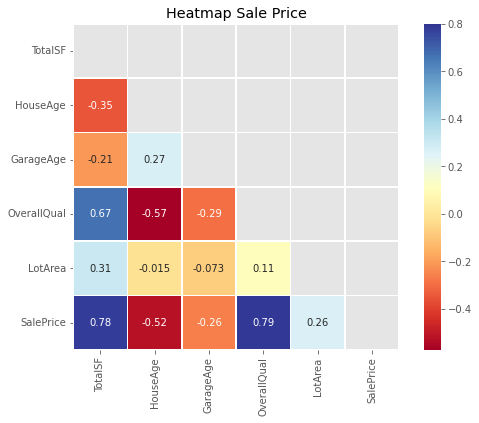

In [15]:
### **View the UNSCALED correlation between select features and target.**

# Create a correlation heatmap to find out which 4 variables -AA (Chad added sq ft)
# "HouseAge", "OverallQual", "LotArea" is more correlated with "SalePrice" 
# Create a df for correlation.
columns = ['TotalSF', 'HouseAge','GarageAge','OverallQual','LotArea','SalePrice']
df_corr = train[columns]
# setting up the heatmap
corrmat = df_corr.corr()

# mask similar squares
mask = np.triu(np.ones_like(corrmat,dtype=bool))

# set the figure size
f, ax = plt.subplots(figsize=(9, 6))

# pass the data and set the parameters
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, cmap='RdYlBu', linewidths=.5, mask=mask)
plt.title('Heatmap Sale Price')

In [16]:
## Another way to view the correlation between features and target. -cpg
## Categorical features are not represented... need to convert via dummies.
corr_matrix = train.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice         1.000000
OverallQual       0.790982
TotalSF           0.782260
GrLivArea         0.708624
GarageCars        0.640409
GarageArea        0.623431
TotalBathrooms    0.613005
TotRmsAbvGrd      0.533723
YearBuilt         0.522897
YearRemodAdd      0.507101
MasVnrArea        0.472614
Fireplaces        0.466929
WoodDeckSF        0.324413
OpenPorchSF       0.315856
LotArea           0.263843
BsmtUnfSF         0.214479
LotFrontage       0.209624
BedroomAbvGr      0.168213
ScreenPorch       0.111447
PoolArea          0.092404
MoSold            0.046432
3SsnPorch         0.044584
MiscVal          -0.021190
Id               -0.021917
YrSold           -0.028923
OverallCond      -0.077856
MSSubClass       -0.084284
EnclosedPorch    -0.128578
KitchenAbvGr     -0.135907
GarageAge        -0.261441
HouseAge         -0.523350
Name: SalePrice, dtype: float64

In [17]:
## Look at scatter matrix of some higher correlated features. -cpg
##from pandas.plotting import scatter_matrix
##top_five_features = ['OverallCond','OverallQual','TotalSF','GrLivArea', 'HouseAge','GarageCars','SalePrice']
##scatter_matrix(train[top_five_features], figsize=(20, 15))

In [18]:
## EDA focus in on one of the higher correlated features. -cpg
## f = train.plot(kind="scatter", x="TotalSF", y="SalePrice", alpha=0.1,figsize=(9, 6))


### **View the non-numerical features. GetDummies, etc., for all non-numerical data.**

In [19]:
## Separate numerical and non-numerical features.
non_numerical = train.select_dtypes(exclude=['int64','float64'])
numerical = train.select_dtypes(exclude=['object'])
## Show how many unique values within each non-numerical feature.
non_numerical.astype(str)
non_numerical.nunique(dropna=False)


MSZoning          5
Street            2
Alley             3
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        5
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          5
BsmtCond          5
BsmtExposure      5
BsmtFinType1      7
BsmtFinType2      7
Heating           6
HeatingQC         5
CentralAir        2
Electrical        6
KitchenQual       4
Functional        7
FireplaceQu       6
GarageType        7
GarageFinish      4
GarageQual        6
GarageCond        6
PavedDrive        3
PoolQC            4
Fence             5
MiscFeature       5
SaleType          9
SaleCondition     6
dtype: int64

In [20]:
## Show list of non-numerical feature names.
columns_1hot = non_numerical.columns.to_list()
# get dummy variables for all cat. variables
train_dummies = pd.get_dummies(train[columns_1hot])
#drop categorical columns and the Id
train = train.drop(columns= columns_1hot)
# create a new df with dummy variables
train_with_dummies = pd.concat([train,train_dummies], axis= 'columns')
# drop one of the dummy variable columns so we don't have a dummy variable trap.
train_with_dummies = train_with_dummies.drop('SaleCondition_Normal', axis = 1)
##train_with_dummies.info()
print(f"Train features, including dummies: {len(train_with_dummies.columns)}")


# get dummy variables for all cat. variables
test_dummies = pd.get_dummies(test[columns_1hot])
#drop categorical columns and the Id
test = test.drop(columns= columns_1hot)
# create a new df with dummy variables
test_with_dummies = pd.concat([test,test_dummies], axis= 'columns')
test_with_dummies = test_with_dummies.drop('SaleCondition_Normal', axis = 1)

## Putting Target Feature in the last position of dataframe for easy reference.
last_column = train.pop('SalePrice')
train['SalePrice']=last_column
##train.info()

print(f"Test features, including dummies: {len(test_with_dummies.columns)}")
### Train set may have more dummies features, as some categorical values
### may not have been present in the Test set...
###  We see only 284 here, but 297 in Train.
###  It should not matter, as we are only selecting those 
### features with correlation to target above stated threshold.

Train features, including dummies: 298
Test features, including dummies: 285


In [21]:
# Get missing columns in the training test
missing_cols = set(train_with_dummies.columns) - set(test_with_dummies.columns)

# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test_with_dummies[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
test_with_dummies = test_with_dummies[train_with_dummies.columns]
test_with_dummies = test_with_dummies.drop('SalePrice', axis = 1)

print(f"Test features, including dummies: {len(test_with_dummies.columns)}")

Test features, including dummies: 297


# **Scale the features.**

In [22]:
### perform standard scaling 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [23]:
# perform standard scaling transformation   
train_scaled = train_with_dummies
col_names = train_with_dummies.columns.to_list()

## We remove the target feature from scaling. -cpg
col_names.remove('SalePrice')

## We remove the ID column as it is not a feature. -cpg
col_names.remove('Id')
features = train_scaled[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
train_scaled[col_names] = features
print(f"total Train features to choose from: {len(train_scaled.columns)}")

total Train features to choose from: 298


In [24]:
# perform standard scaling transformation   
test_scaled = test_with_dummies
col_names = test_with_dummies.columns.to_list()

## We remove the ID column as it is not a feature. -cpg
col_names.remove('Id')
features = test_scaled[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
test_scaled[col_names] = features

print(f"total scaled features (+dummies) to choose from: {len(test_scaled.columns)}")

total scaled features (+dummies) to choose from: 297


In [25]:
# Create the predictors and response for the model
y = train_scaled['SalePrice']
X = train_scaled.drop(columns='SalePrice')
X.shape, y.shape

((1460, 297), (1460,))

In [26]:
# split data for cross-validation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=31) ##, random_state=31
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((876, 297), (876,), (584, 297), (584,))

# Ridge Regression

In [27]:
# Load libraries
from sklearn.linear_model import RidgeCV

## generate range of alphas to test
## alpha_list_ridge = np.logspace(-10, 100, 10000)
alpha_list_ridge = 10**np.linspace(10,-2,1000)*0.5
## alpha_list_ridge = np.linspace(0, 10, num=400)
regr_cv = RidgeCV(alphas=alpha_list_ridge)
model_cv = regr_cv.fit(X_train, y_train)
# View BEST alpha
model_cv.alpha_

310.286440338825

In [28]:
len(alpha_list_ridge)

1000

In [29]:
## Using Ridge Regression model:

from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=model_cv.alpha_, solver="cholesky", random_state=31) ##, 
ridge_reg.fit(X_train, y_train)
score_ridge_train = ridge_reg.score(X_train, y_train)
print(f"Ridge train score : {score_ridge_train}")
score_ridge_test = ridge_reg.score(X_test, y_test)
print(f"Ridge test score : {score_ridge_test}")

Ridge train score : 0.9299698531469781
Ridge test score : 0.8635362270608253


In [30]:
from sklearn.metrics import mean_squared_error

##ridge_reg.predict(X_pred)
ridge_predict = ridge_reg.predict(test_scaled)  # Use this model to predict the test data
ridge_predict.shape

##print(pd.Series(ridge_reg.coef_, index = X_test.columns)) # Print coefficients
##print(mean_squared_error(y_test, ridge_predict))        # Calculate the test MSE

(1459,)

In [31]:
##ridge_reg.predict(X_pred)
ridge_predict = ridge_reg.predict(test_scaled)  # Use this model to predict the test data
ridge_predict.shape

(1459,)

In [32]:
# Create a dataframe for results to be submitted 
results = pd.DataFrame(test_scaled[['Id']], columns= ['Id'])
##results['SalePrice'] = lasso_predict
results['SalePrice'] = ridge_predict
print(results.shape)

(1459, 2)


In [33]:
from datetime import datetime
date = str(datetime.now().strftime("%Y_%m_%d-%I.%M%p"))
filename=(f"Ridge_test_predict_{date}.csv")
results.to_csv(filename, index=False)

# LASSO (Least Absolute Shrinkage and Selection Operator)

In [34]:
## Using Lasso Regression model:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression


#alpha needs to equal ~10k before factor reduction, may need to use more predictors
alpha_dict = {}
r_squared_dict = {}
lasso = Lasso(alpha=1,max_iter = 10000) ##, normalize = True
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print("training score:", train_score)
print ("test score: ", test_score)
print ("number of features used: ", coeff_used)

training score: 0.9520211191599701
test score:  0.74007554411594
number of features used:  249


In [35]:
## get Lasso predictions of y for the test portion of Train data set.
y_test_predic2222 = lasso.predict(X_test)

In [36]:
cross_val_df222 = pd.DataFrame(y_test_predic2222, columns = ['PredictedPrice'])
cross_val_df222['ActualPrice']= y_test.values
cross_val_df222.head()

,PredictedPrice,ActualPrice
0,283201.478985,200500
1,133999.558801,144000
2,123215.470826,147000
3,155874.956199,138887
4,132512.785502,119900


In [37]:
# find the correlation between the two
cv_df_corr = cross_val_df222.corr()
cv_df_corr

,PredictedPrice,ActualPrice
PredictedPrice,1.000000,0.884528
ActualPrice,0.884528,1.000000


In [38]:
alpha_list = list(range(0, 15000, 100))
alpha_vs_features_dict = {}
train_score_dict = {}
test_score_dict = {}
r_squared_dict = {}
for alpha in alpha_list:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train,y_train)
    train_score=lasso.score(X_train,y_train)
    test_score=lasso.score(X_test,y_test)
    coeff_used = np.sum(lasso.coef_!=0)
    alpha_vs_features_dict[alpha] = coeff_used
    train_score_dict[alpha]= train_score
    test_score_dict[alpha] = test_score
    y_test_prediction = lasso.predict(X_test)
    cross_validation_frame = pd.DataFrame(y_test_prediction, columns = ['PredictedPrice'])
    cross_validation_frame['ActualPrice']= y_test.values
    r_squared = (cross_validation_frame.corr()['ActualPrice'][0])**2
    r_squared_dict[alpha] = r_squared

In [39]:
print(alpha_list[0:10])

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900]


In [40]:
test_score_dict

{0: -20045.920624260496,
 100: 0.8264981867599209,
 200: 0.8370714109429828,
 300: 0.8409131083892901,
 400: 0.844190956055943,
 500: 0.8470778605894749,
 600: 0.8497955331962668,
 700: 0.8523016822410848,
 800: 0.8539900905070583,
 900: 0.8552357347305349,
 1000: 0.8561188080787013,
 1100: 0.856872865727416,
 1200: 0.8574560518399512,
 1300: 0.8578378294166873,
 1400: 0.8580065890848418,
 1500: 0.8581226294328723,
 1600: 0.8582630970012319,
 1700: 0.8582975945273645,
 1800: 0.8582559967610213,
 1900: 0.8581400765231522,
 2000: 0.8579212719661954,
 2100: 0.8578249996191487,
 2200: 0.8576457215748385,
 2300: 0.8573842903339576,
 2400: 0.8570505654343119,
 2500: 0.8566259287381879,
 2600: 0.8561125574809634,
 2700: 0.8554278171261707,
 2800: 0.8546319927976888,
 2900: 0.8537618347076277,
 3000: 0.8528525976768224,
 3100: 0.8519582497821825,
 3200: 0.8510257394243125,
 3300: 0.8501026228576454,
 3400: 0.8491261521658597,
 3500: 0.8480944400655122,
 3600: 0.8470036719847283,
 3700: 0.84585

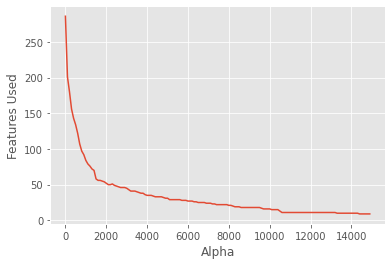

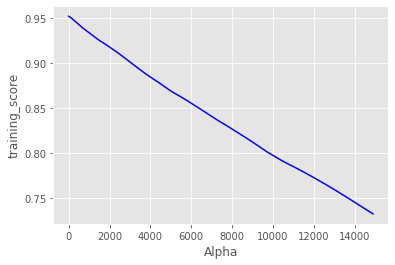

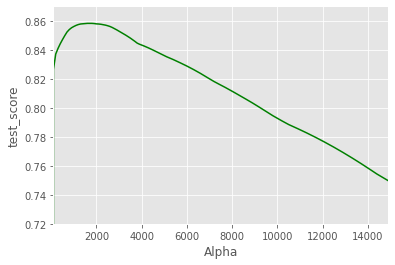

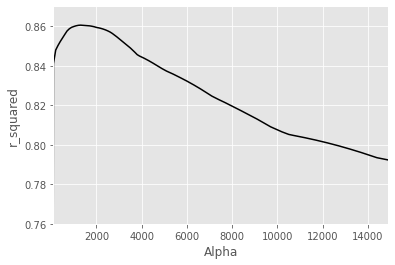

In [41]:
features = sorted(alpha_vs_features_dict.items())
a, b = zip(*features)
plt.plot(a, b)
plt.xlabel("Alpha")
plt.ylabel("Features Used")
plt.show()

train_sc = sorted(train_score_dict.items())
c, d = zip(*train_sc)
plt.plot(c, d, color="blue")
plt.xlabel("Alpha")
plt.ylabel("training_score")
plt.show()

test_sc = sorted(test_score_dict.items())
e, f = zip(*test_sc)
plt.plot(e, f, color="green")
plt.xlabel("Alpha")
plt.ylabel("test_score")
plt.xlim([alpha_list[1], alpha_list[-1]])
plt.ylim([0.72, 0.87])
plt.show()

r_sq = sorted(r_squared_dict.items())
g, h = zip(*r_sq)
plt.plot(g, h, color="black")
plt.xlabel("Alpha")
plt.ylabel("r_squared")
plt.xlim([alpha_list[1], alpha_list[-1]])
plt.ylim([0.76, 0.87])
plt.show()

In [42]:
max_alpha_for_r_squared = max(r_squared_dict, key=r_squared_dict.get)
max_alpha_for_r_squared

1300

In [43]:
## apply Lasso model to Test data set:
lasso = Lasso(alpha=max_alpha_for_r_squared)
lasso_reg = lasso.fit(X_train, y_train)
train_score=lasso.score(X_train, y_train)
test_score=lasso.score(X_test, y_test)
coeff_used = np.sum(lasso.coef_!=0)

y_test_prediction = lasso.predict(X_test)
cross_validation_frame = pd.DataFrame(y_test_prediction, columns = ['PredictedPrice'])
cross_validation_frame['ActualPrice']= y_test.values
r_squared = (cross_validation_frame.corr()['ActualPrice'][0])**2

In [44]:
print("training score:", train_score)
print ("test score: ", test_score)
print ("number of features used: ", coeff_used)

training score: 0.9284278861117515
test score:  0.8578378294166873
number of features used:  72


In [45]:
cross_validation_frame

,PredictedPrice,ActualPrice
0,244353.549320,200500
1,136352.848946,144000
2,125166.217538,147000
3,156828.857952,138887
4,110499.277368,119900
...,...,...
579,216198.615181,179900
580,159590.543341,157900
581,166757.592597,165000
582,120017.390809,128000


In [46]:
r_squared

0.8604935573348511

In [47]:
from sklearn.metrics import mean_squared_error

##ridge_reg.predict(X_pred)
lasso_predict = lasso_reg.predict(test_scaled)  # Use this model to predict the test data
lasso_predict.shape

(1459,)

In [48]:
# Create a dataframe for results to be submitted 
lasso_results = pd.DataFrame(test_scaled[['Id']], columns= ['Id'])
##results['SalePrice'] = lasso_predict
lasso_results['SalePrice'] = lasso_predict
print(lasso_results.shape)

(1459, 2)


In [49]:
os.getcwd()

'/content/MSDS422_course_assignments'

In [50]:
from datetime import datetime
date = str(datetime.now().strftime("%Y_%m_%d-%I.%M%p"))
filename=(f"Lasso_test_predict_{date}.csv")
results.to_csv(filename, index=False)

##Elastic Net Regression

In [51]:
from sklearn.linear_model import ElasticNet
>>> elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
>>> elastic_net.fit(X_train, y_train)
>>> price_pred_elas = elastic_net.predict(X_test)

In [52]:
# create a dataframe with the predicted sale price using Ealstic Net for the x_test and the actual prices from y_test

model_accu_df = pd.DataFrame(price_pred_elas, columns = ['price_pred_elas'])
model_accu_df['ActualPrice']= y_test.values
model_accu_df.head()

,price_pred_elas,ActualPrice
0,270447.007524,200500
1,136751.834436,144000
2,123635.829804,147000
3,158420.276199,138887
4,132382.276150,119900


In [53]:
# find the correlation between the two
model_accu_df_corr = model_accu_df.corr()
model_accu_df_corr

,price_pred_elas,ActualPrice
price_pred_elas,1.000000,0.922121
ActualPrice,0.922121,1.000000


In [54]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

parametersGrid = {"max_iter": [1, 5, 10], \
                  "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],\
                  "l1_ratio": np.arange(0.0, 1.0, 0.1)}

eNet = ElasticNet()
grid = GridSearchCV(eNet, parametersGrid, scoring='r2', cv=5)
grid.fit(X_train, y_train)


##print(eNet.coef_[0:10], eNet.intercept_)

GridSearchCV(cv=5, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'max_iter': [1, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [55]:
y_test_prediction = grid.predict(X_test)
cross_validation_frame = pd.DataFrame(y_test_prediction, columns = ['PredictedPrice'])
cross_validation_frame['ActualPrice']= y_test.values
r_squared = (cross_validation_frame.corr()['ActualPrice'][0])**2

In [57]:
train_score=grid.score(X_train,y_train)
test_score=grid.score(X_test,y_test)
print("training score:", train_score)
print ("test score: ", test_score)


training score: 0.9167028206970783
test score:  0.8630657352439284


In [58]:
elastic_predict = grid.predict(test_scaled)
elastic_predict.shape

(1459,)

In [59]:
# Create a dataframe for results to be submitted 
elastic_results = pd.DataFrame(test_scaled[['Id']], columns= ['Id'])
elastic_results['SalePrice'] = elastic_predict
print(elastic_results.shape)

(1459, 2)


In [60]:
elastic_results.head()

,Id,SalePrice
0,1461,109312.122218
1,1462,150290.305493
2,1463,193931.879660
3,1464,207577.234525
4,1465,195952.875394


In [61]:
from datetime import datetime
date = str(datetime.now().strftime("%Y_%m_%d-%I.%M%p"))
filename=(f"Elastic_test_predict_{date}.csv")
elastic_results.to_csv(filename, index=False)

# OLS model and predictions

In [69]:
## Initial OLS model, without feature selection.

## Loading in the statsmodels package to do a quick check on the train data set.
import statsmodels.api as sm
import statsmodels.formula.api as smf
## statsmodels uses Patsy package to describe our model.
## the first position is the target, and 'X' contains all relevant features.
est = smf.ols('SalePrice ~ X', train).fit()
##print(est.params)
print(est.rsquared)

## the following can be used to show the Summary attributes.
##for attr in dir(est):
  ##  if not attr.startswith('_'):
    ##    print(attr)

0.9325946876921184


## From the correlation matrix we pick only the variables that have a correlation coef. above a stated threshold for the model ... plus the dummy variable columns.

In [88]:
## Establish a correlation matrix between all features and Target.

## Convert all correlation to positive, so threshold can grab those features
## most directly and indirectly related to Target.
corr_matrix = train_scaled.corr().abs()


##corr_matrix['SalePrice'].abs()
##corr_matrix.head()

In [91]:
len(corr_matrix)

298

In [89]:
all_features = corr_matrix["SalePrice"].sort_values(ascending=False).to_frame()

In [90]:
## Look at the correlation values.
print(all_features.head())
print(all_features.tail())

             SalePrice
SalePrice     1.000000
OverallQual   0.790982
TotalSF       0.782260
GrLivArea     0.708624
GarageCars    0.640409
                   SalePrice
Foundation_Wood     0.002711
GarageCond_Gd       0.000983
RoofStyle_Mansard   0.000308
RoofMatl_Metal      0.000304
BsmtFinType2_GLQ    0.000076


In [92]:
keep_threshold = 0.2

In [93]:
## Get list of features to keep, based on correlation threshold.
train_scaled_keep_list = all_features[all_features['SalePrice']>=keep_threshold].index.to_list()
train_scaled_keep_list.remove('SalePrice')
len(train_scaled_keep_list)

71

In [96]:
# Using sklearn linear regression module:

## Build the model
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
est = lin_reg.fit(X_train, y_train)
print(est.score(X_train, y_train))
est2 = lin_reg.fit(X_test, y_test)
print(est2.score(X_test, y_test))
print(lin_reg.intercept_)
print(len(lin_reg.coef_))

0.9520234752330257
0.9320315171145388
183201.02497412436
297


In [ ]:
## Get all the predictor features.
X_pred = test_scaled['X_keep_list']  ## list is generated based on threshold
len(X_pred.columns)

In [97]:

y_test_predic = lin_reg.predict(X_test)
##y_test_predic[0:10]

In [194]:
# create a dataframe with the predicted sale price for the x_test and the actual prices from y_test

cross_val_df = pd.DataFrame(y_test_predic, columns = ['PredictedPrice'])
cross_val_df['ActualPrice']= y_test.values
print(cross_val_df.head())
# find the correlation between the two
cross_val_df.corr()

   PredictedPrice  ActualPrice
0   283414.258690       200500
1   134009.830956       144000
2   123422.682762       147000
3   155789.897362       138887
4   132596.671600       119900


,PredictedPrice,ActualPrice
PredictedPrice,1.000000,-0.112228
ActualPrice,-0.112228,1.000000


In [177]:
# Calculate R^2
correl = 0.923707
R_sq = correl*correl
R_sq

0.8532346218489999

### **Get predictions for the test set**

In [ ]:
## Get all the predictors 
x_pred = test_scaled[train_scaled_keep_list]

In [ ]:
# Use Sklearn model to get predictions
price_predic = lin_reg.predict(x_pred)
price_predic.shape

(1459,)

In [ ]:
# Create a dataframe for results to be submitted 
results = pd.DataFrame(test_scaled[['Id']], columns= ['Id'])
results['SalePrice'] = price_predic
results.shape

(1459, 2)

In [ ]:
os.getcwd()

'/content/MSDS422_course_assignments'

In [ ]:
from datetime import datetime
date = str(datetime.now().strftime("%Y_%m_%d-%I.%M%p"))
filename=(f"OLS_test_predict_{date}.csv")
results.to_csv(filename, index=False)